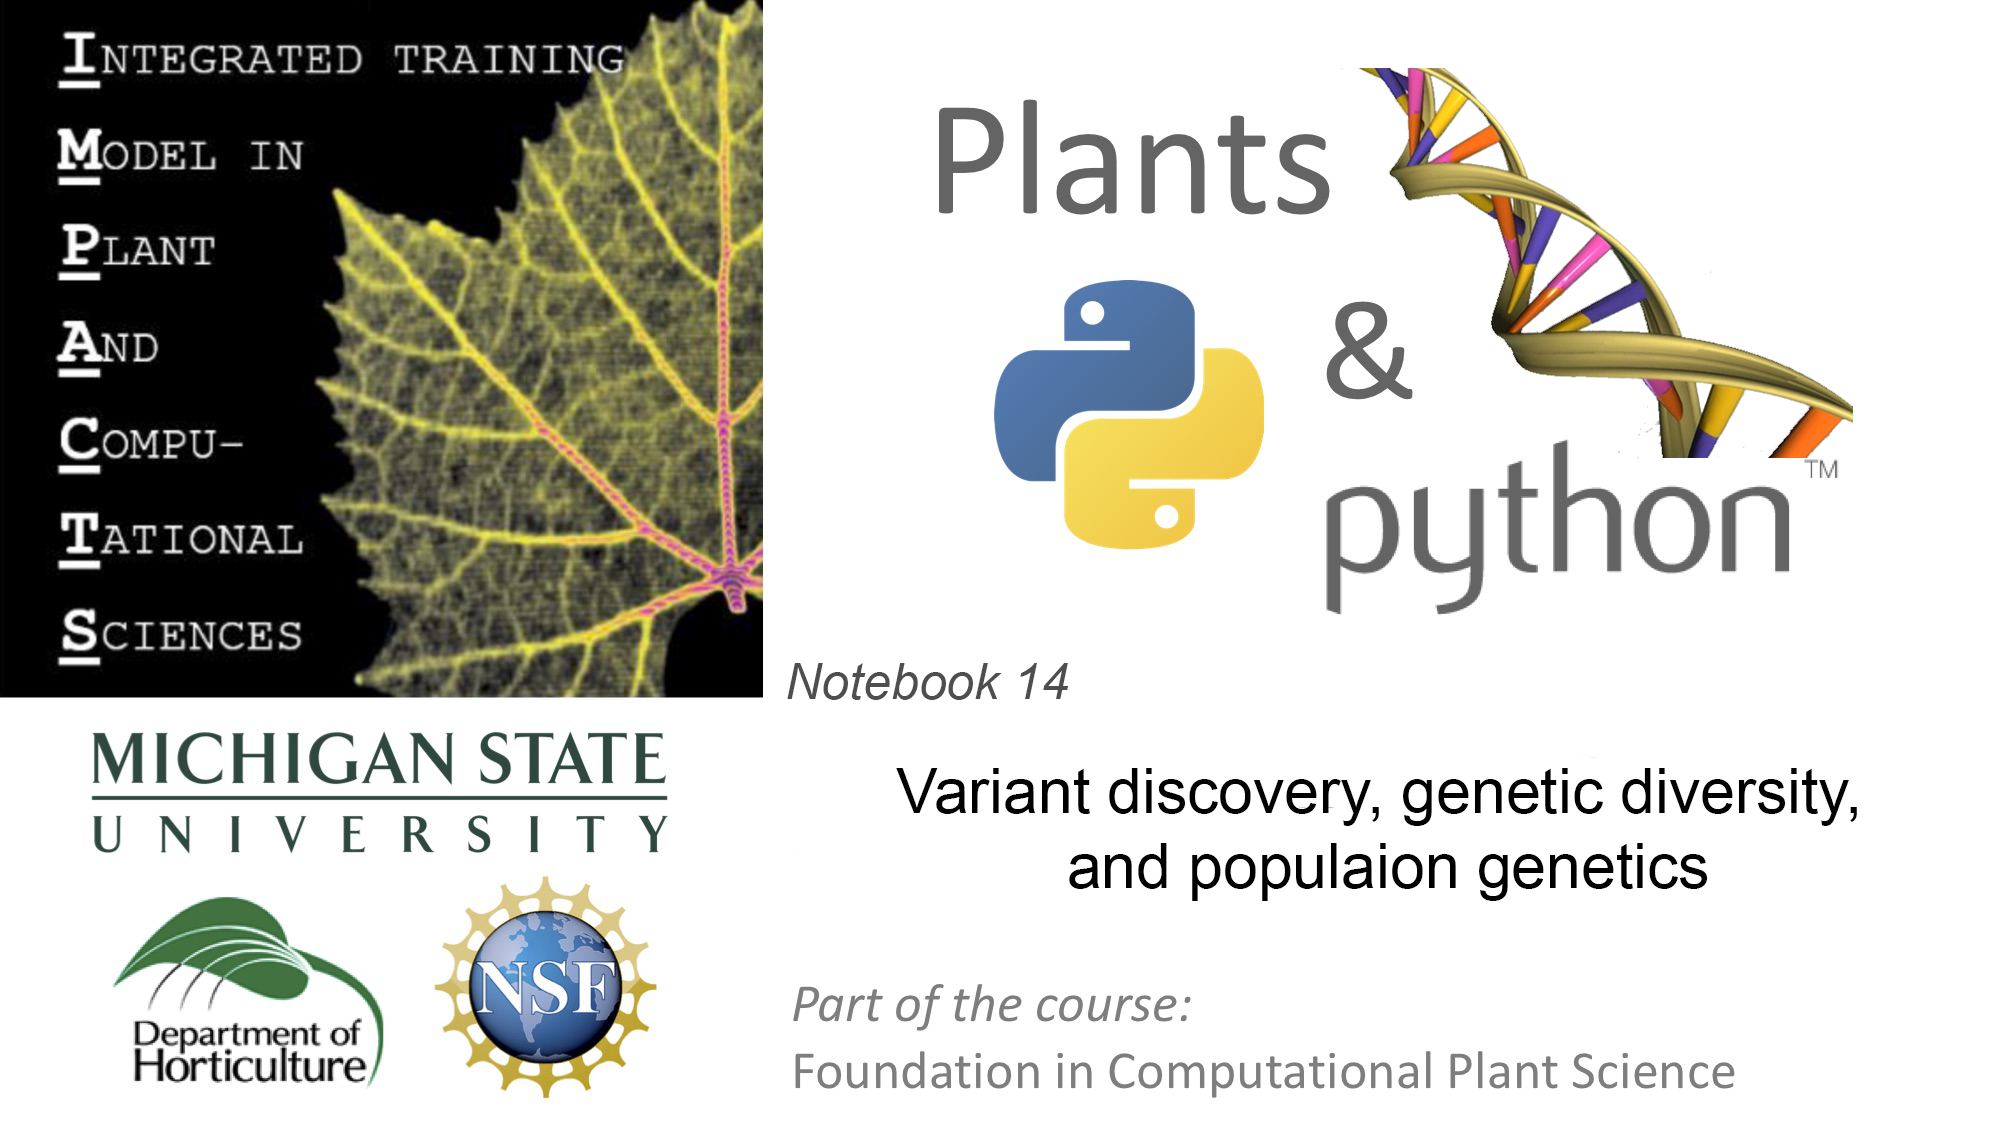

So far we have seen how Illumina short read data can be used to quantify elements in the genome (e.g. gene expression, small RNAs, chromatin accessibility, and transcription factor binding). These approaches align the reads against a reference genome for quantification, but ignore the actual sequence information contained in the reads. In RNAseq data for instance, there can be differences between the RNAseq reads and the reference sequence, but we ignore this information as we only care about how many reads align per gene. What if we care about the actual sequence? <br>
<br>
We can use Illumina data to identify differences between a reference genome and another individual. We could look at differences across varieties, cultivars or accessions of a crop plant. We could sequence siblings in a mapping population and identify which alleles they have. We could also identify causal mutations in an EMS, fast neutron, or transposon based mutant populaton. In all of these cases the workflow is the same, and the first step is to identify _variants_ or differences between the reference genome and our individual of interest. Using Illumina data, we can identify single nucleotide polymorphisms (or SNPs) which represent base pair differences (e.g. A -> G, C -> T, etc.), or we can identify short insertions or deletions (InDels) which represent differences that span a couple base pairs (e.g. a deletion of ACC or an insertion of GTGA). <br> <br>
Identifying variants is significantly more computationally intensive than mapping RNAseq data, so we will not be doing it in this notebook (but the workflow is described below for those who are interested). Instead, we will learn about how to manipultate the output variant dataframes (VCF files) and simple downstream analyses of genetic diversity and population genetics. In this notebook, we will work with variant data for wild and domesticated pineapple and grape, but these approaches can be applied to your favorite species!

# Identifying variants

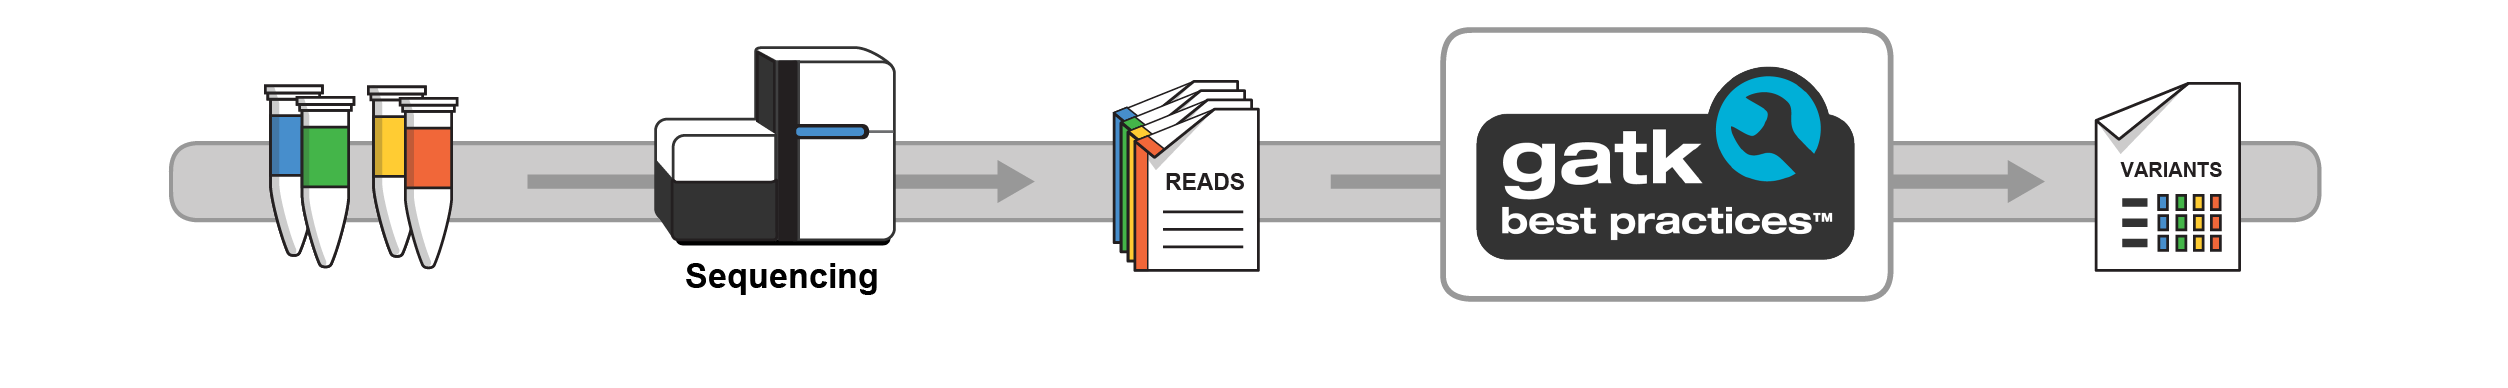

The first step of variant discovery is the same as the RNAseq pipeline: we need to align Illumina reads against a  reference genome. Unlike RNAseq, where we can _quasimap_ or _pseudoalign_ reads to figure out the relative position for quantification, we need to know the exact alignment, at base pair resolution, to accurately identify differences between reads and the reference. We can use several aligners to do this, but the leading ones are **bowtie2** and **bwa**. After alignmnet, we need to filter out PCR duplicates,  sort the data, and feed it into the Genome Analysis Toolkit (GATK). GATK is the gold standard for identifying variants (_for now_), and the workflow can be found below.  
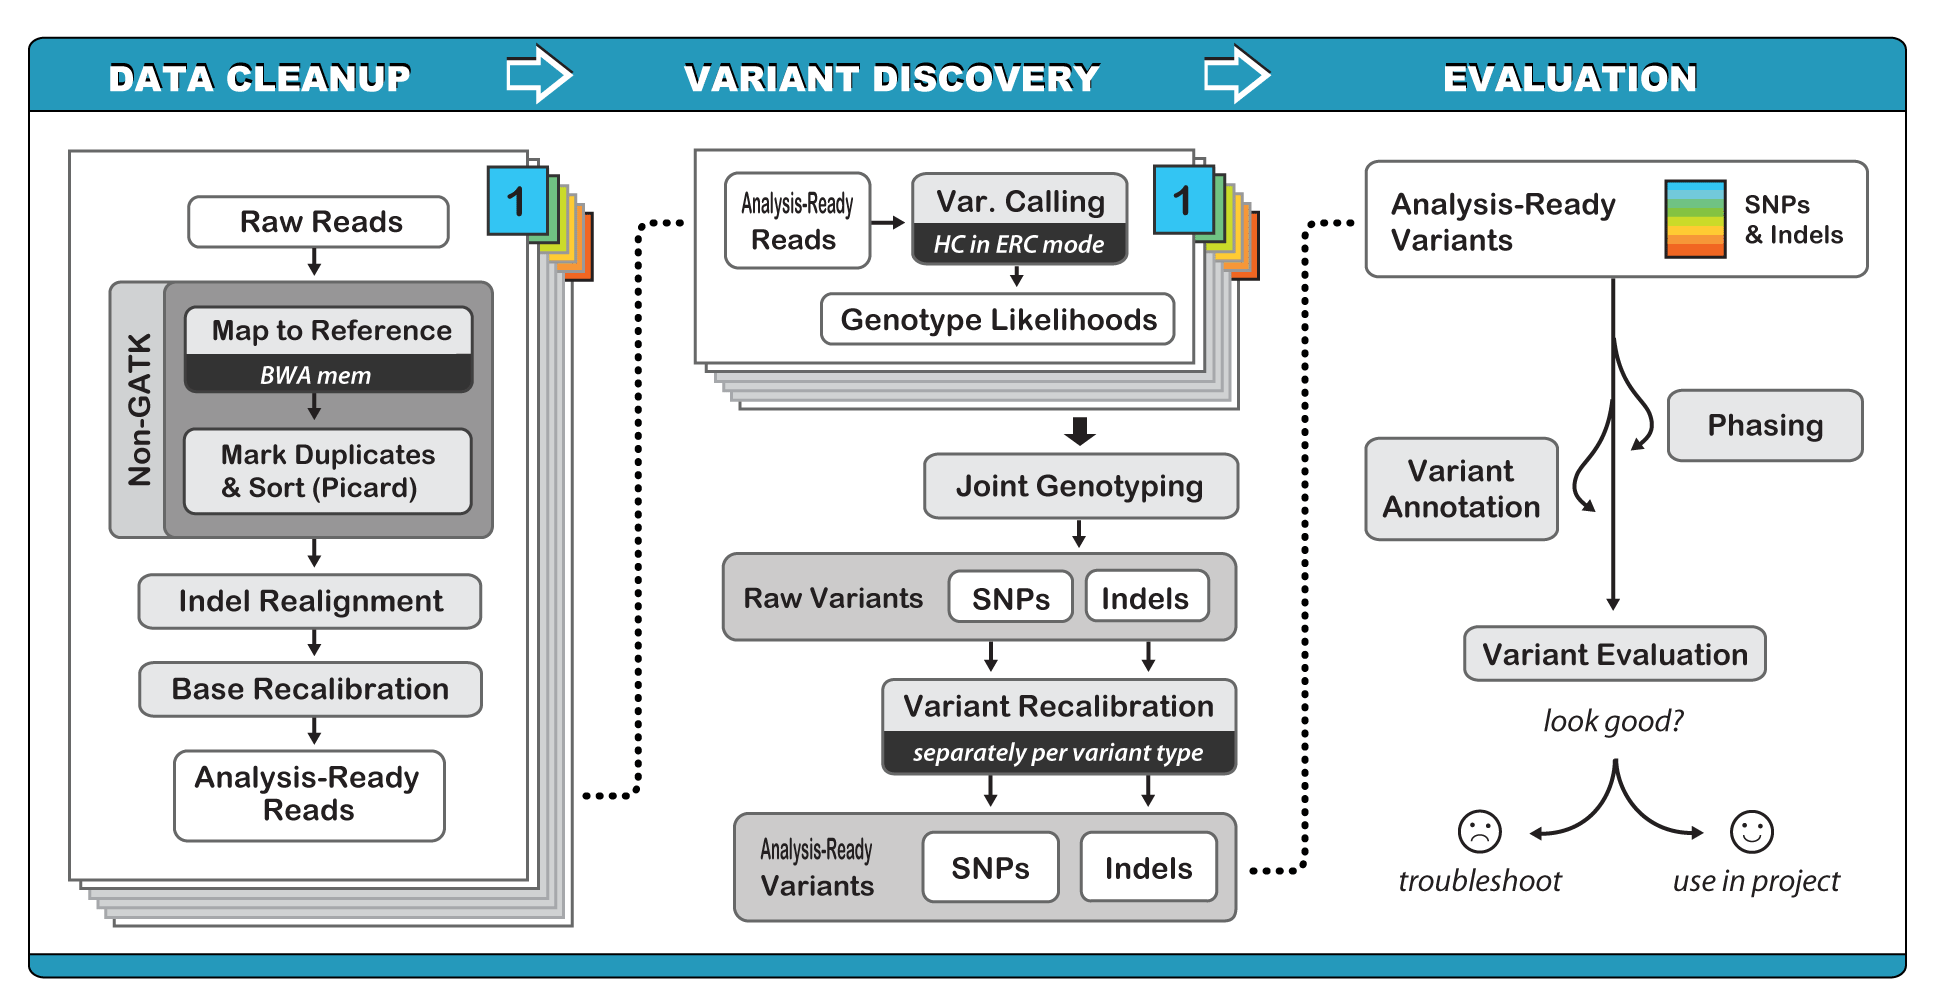
<br>

GATK offers a wide variety of tools with a primary focus on variant discovery and genotyping. Its powerful processing engine and high-performance computing features make it capable of taking on projects of any size. GATK is a beast, and we could spend weeks discussing best practices for identifing variants. Accurately identifying variants is challenging in even the simplest systems, and it scales in difficulty for polyploids, highly repetitive genomes, and highly diverse or heterozygous species. The simplified workflow is outlined above, and the central algorithm of variant detection, the `HaplotypeCaller` is outlined below.
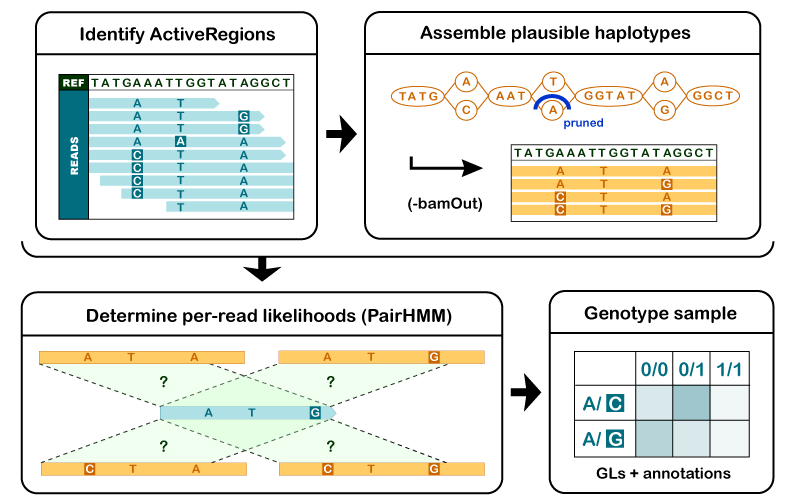
1. First, the program determines which regions of the genome it needs to operate on, based on the presence of significant evidence for variation.
2. For each ActiveRegion, the program builds a De Bruijn-like graph to reassemble the ActiveRegion and identifies what are the possible haplotypes present in the data. The program then realigns each haplotype against the reference haplotype using the Smith-Waterman algorithm in order to identify potentially variant sites.
3. For each ActiveRegion, the program performs a pairwise alignment of each read against each haplotype using the PairHMM algorithm. This produces a matrix of likelihoods of haplotypes given the read data. These likelihoods are then marginalized to obtain the likelihoods of alleles per read for each potentially variant site.
4.  For each potentially variant site, the program applies Bayes’ rule, using the likelihoods of alleles given the read data to calculate the posterior likelihoods of each genotype per sample given the read data observed for that sample. The most likely genotype is then assigned to the sample.

Read processing and HaplotypeCaller are run separately on each sample in the experiment, and the results are combined, recalibrated, and a dataframe of variants is output in the Variant Call Format (VCF). GATK and the associated processes can be run on HPCC. 

# VCF: a dataframe of variants

The intermediate files for variant calling are huge, and we need a way to visualize, manipulate, and analyze variants across the genome for many individuals. There are several leading formats, but the most common iS the VCF format. Below is an example:

    ##fileformat=VCFv4.0
    ##fileDate=20090805
    ##source=myImputationProgramV3.1
    ##reference=1000GenomesPilot-NCBI36
    ##phasing=partial
    ##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of Samples With Data">
    ##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
    ##INFO=<ID=AF,Number=.,Type=Float,Description="Allele Frequency">
    ##INFO=<ID=AA,Number=1,Type=String,Description="Ancestral Allele">
    ##INFO=<ID=DB,Number=0,Type=Flag,Description="dbSNP membership, build 129">
    ##INFO=<ID=H2,Number=0,Type=Flag,Description="HapMap2 membership">
    ##FILTER=<ID=q10,Description="Quality below 10">
    ##FILTER=<ID=s50,Description="Less than 50% of samples have data">
    ##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
    ##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
    ##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
    ##FORMAT=<ID=HQ,Number=2,Type=Integer,Description="Haplotype Quality">
        #CHROM POS     ID        REF ALT    QUAL FILTER INFO                              FORMAT      Gala        Honeycrisp        Granny_Smith
    Chr_20     14370   rs6054257 G      A       29   PASS   NS=3;DP=14;AF=0.5;DB;H2           GT:GQ:DP:HQ 0|0:48:1:51,51 1|0:48:8:51,51 1/1:43:5:.,.
    Chr_20     17330   .         T      A       3    q10    NS=3;DP=11;AF=0.017               GT:GQ:DP:HQ 0|0:49:3:58,50 0|1:3:5:65,3   0/0:41:3
    Chr_20     1110696 rs6040355 A      G,T     67   PASS   NS=2;DP=10;AF=0.333,0.667;AA=T;DB GT:GQ:DP:HQ 1|2:21:6:23,27 2|1:2:0:18,2   2/2:35:4
    Chr_20     1230237 .         T      .       47   PASS   NS=3;DP=13;AA=T                   GT:GQ:DP:HQ 0|0:54:7:56,60 0|0:48:4:51,51 0/0:61:2
    Chr_20     1234567 microsat1 GTCT   G,GTACT 50   PASS   NS=3;DP=9;AA=G                    GT:GQ:DP    0/1:35:4       0/2:17:2       1/1:40:3

There's a lot to unpack here, but for their complexity, VCF files contain a wealth of useful information. Lines that start with `##` contain info such as the file format, reference genome used, filters, and other useful information. These are largely ignored for any data analysis. 
<br>
There are 8 fixed fields per record (variant). All data lines are tab-delimited. In all cases, missing values are specified with a dot (”.”). Fixed fields are as follows:

1. **CHROM** chromosome: an identifier from the reference genome. Could be a number, Chr_X, or SCAFFOLD_X / Contig_X among others. 
2. **POS** position: The reference position, with the 1st base having position 1. Positions are sorted numerically, in increasing order, within each reference sequence CHROM. (Integer, Required)
3. **ID** semi-colon separated list of unique identifiers where available. This can intuitive or a random string. Can mostly be ignored (Alphanumeric String)
4. **REF** reference base(s): This is the base in the reference genome and each base must be one of A,C,G,T or N for unknown. If this position is an indel (insertion or deletion), it may contain multiple bases.  
5. **ALT** comma separated list of alternate non-reference alleles called on at least one of the samples. This is the variant that was different from the reference. Options are base Strings made up of the bases A,C,G,T,N, or an angle-bracketed ID String. Note, there can be more than one alt. One individual could have a T at this position and another could have a C (while the reference is G) (Alphanumeric String; no whitespace, commas, or angle-brackets are permitted in the ID String itself)
6. **QUAL** phred-scaled quality score for the assertion made in ALT. High QUAL scores indicate high confidence calls. Although traditionally people use integer phred scores, this field is permitted to be a floating point to enable higher resolution for low confidence calls if desired. (Numeric)
7. **FILTER** filter: PASS if this position has passed all filters, i.e. a call is made at this position. Otherwise, if the site has not passed all filters, a semicolon-separated list of codes for filters that fail.(Alphanumeric String)
8. **INFO** Additional information: (Alphanumeric String) INFO fields are encoded as a semicolon-separated series of short keys with optional values in the format: <key>=<data>[,data]. Arbitrary keys are permitted, although the following sub-fields are reserved (albeit optional). 

The genotype fields are next, and these are the most important as these contain the variants . There will be one column for each sample/accession where variants were identified. In this example, that would be Gala, Honeycrisp, or Granny_smith apples. Genotypes can be denoted as: **0/0**, **0/1**, or **1/1** (in general, but there are other possibilities). The first record in this example has a reference allele of G, and the alternative allele is A. 0/0 is homozygous for the reference alleles (AA), 0/1 is heterozygous for the reference and alternate alleles (AG) and 1/1 is homozygous for the alternate allele (GG). ./. indicates missing data.  Now, this is for diploid species, a haploid or monoploid species would have 0 or 1, and a polyploid species would have more. An octoploid (like strawberry or sugarcane) would have eight such as 0/0/0/0/0/1/1/1 or 0/0/1/1/1/1/1/1/1. For simplicity, we will only use diploids!
<br> <br>
Now that we know what a VCF file is, we will learn how to read it, manipulate it, and use it for basic genetic diversity and population genetics analyses. 

# Reading, manipulating, and analyzing VCF files

Like everything, there are many programs that we can use to read, manipulate, and analyze VCF files. There is even a python package! Here, we will use the package `scikit-allel` and analyze  filtered VCF files from pineapple and grape (Vitis species). GATK produces a large raw VCF file that needs to be filtered (10-1,000 gigabytes, depending on how many variants, individuals, and genome size). Its not uncommon to get 10 or even 100 million variants in a project, and not all of these are high confidence, and for some analyses, you only need a subset of the data. We can use `scikit-allel` to filter VCF files, but it is slow. The best program to filter VCF files is VCF-tools and it can be run on HPCC. It has a lot of functionality and can also be used for basic population genetics and genetic diversity analyses: <br>
https://vcftools.github.io/man_latest.html
<br>
I have already used VCFtools to filter both the pineapple and grape datasets to make them more manageable for this notebook. We will import the filted files. 

The `scikit-allel` package provides utilities for exploratory analysis of large scale genetic variation data. It is based on numpy, scipy and other general-purpose Python scientific libraries. We need to install `scikit-allel`, and the simplest way is to use Conda. Conda quickly installs, runs and updates packages and their dependencies. Conda easily creates, saves, loads, and switches between environments on your local computer. You should be able to install it by running the following command in Jupyter, but you can also run this on the Anaconda command prompt: 



In [ ]:
conda install -c conda-forge scikit-allel

Once 'conda install' is run, we can verify that the package was installed correctly. 

In [1]:
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.2.1


We'll need some other stuff too: 

In [2]:
import random
random.seed(42)
import time
import numpy as np
np.random.seed(42)
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel

The first step is to read in the vcf file, and we'll do this using allel.read_vcf. We will use `fields='*'` to import all the fields:

In [3]:
pineapple = allel.read_vcf('data/pineapple_downsampled.vcf', fields='*')

Now lets look at the vcf file we imported: 

In [4]:
print(pineapple)

{'samples': array(['Ac73p', 'Ac71q', 'Ac64s', 'Ac68s', 'Ac70q', 'Ac63s', 'Ac62s',
       'Ac61q', 'Ac72q', 'Ac74p', 'A01', 'Aa02', 'Aa03', 'Aa04', 'Aa05',
       'Aa06', 'Aa07', 'Aa08', 'Ac20q', 'Ab10', 'Ab11', 'Ab12', 'Ab13',
       'Ab14', 'Ab15', 'Ab16', 'Ac17c', 'Ac18c', 'Ac19s', 'Ab09', 'Ac21c',
       'Ac22a', 'Ac23c', 'Ac24a', 'Ac25', 'Ac26', 'Ac27', 'Ac28', 'Ac29',
       'Ac30', 'Ac31', 'Ac32s', 'Ac33c', 'Ac34', 'Ac35', 'Ac36', 'Ac37',
       'Ac38c', 'Ac39c', 'Ac40s', 'Ac41c', 'Ac42c', 'Ac43c', 'Ac44c',
       'Ac45c', 'Ac46c', 'Ac47c', 'Ac48', 'Ac49', 'Ac50', 'Ae51', 'Ae52',
       'Cs53', 'Ac80', 'Ac67s', 'Ac78s', 'Ac76s', 'Ac60s', 'Ac85s',
       'Ac66s', 'Ac86m', 'Ac81', 'Ac59p', 'Ac58s', 'Ac82', 'Ac57q',
       'Ac83', 'Ac69s', 'Ac65m', 'Ac56m', 'Ac87s', 'Aa88', 'Ac89s',
       'Ac79s', 'Ac75m', 'Ac84', 'Ac77m'], dtype=object), 'calldata/AD': array([[[-1, -1, -1, -1],
        [16,  8, -1, -1],
        [10, 12, -1, -1],
        ...,
        [-1, -1, -1, -1],
        [-1, 

This is basically a raw NumPy array, so it's not intuitive to read if you are a human.  We can import it as a dataframe instead, so that we fellow humans can interpret it. **Note:** we aren't going to do anything with this, _but you could_. 


In [5]:
pineapple_df = allel.vcf_to_dataframe('data/pineapple_downsampled.vcf', fields='*', alt_number=2)


NameError: name 'grape_df' is not defined

The  object returned by read_vcf() is a Python dictionary with several NumPy arrays, each of which can be accessed via a key. Lets see the available keys:

In [6]:
sorted(pineapple.keys())

['calldata/AD',
 'calldata/DP',
 'calldata/GQ',
 'calldata/GT',
 'calldata/MIN_DP',
 'calldata/PL',
 'calldata/SB',
 'samples',
 'variants/AC',
 'variants/AF',
 'variants/ALT',
 'variants/AN',
 'variants/BaseQRankSum',
 'variants/CHROM',
 'variants/ClippingRankSum',
 'variants/DP',
 'variants/DS',
 'variants/END',
 'variants/FILTER_LowQual',
 'variants/FILTER_PASS',
 'variants/FS',
 'variants/HaplotypeScore',
 'variants/ID',
 'variants/InbreedingCoeff',
 'variants/MLEAC',
 'variants/MLEAF',
 'variants/MQ',
 'variants/MQ0',
 'variants/MQRankSum',
 'variants/POS',
 'variants/QD',
 'variants/QUAL',
 'variants/REF',
 'variants/ReadPosRankSum',
 'variants/altlen',
 'variants/is_snp',
 'variants/numalt']

The `samples` array contains sample identifiers extracted from the header line in the VCF file. We can use these later on when we plot things:



In [ ]:
pineapple['samples']

Now, lets take a step back, where did this data come from? This data is from a recent paper on the domestication history of pineapple: 
https://www.nature.com/articles/s41588-019-0506-8

In this paper we resequenced ~90 accessions of pineapple from around the world and a few dozen wild species as well. We will be replicating a few of the analyses in this paper. <br>

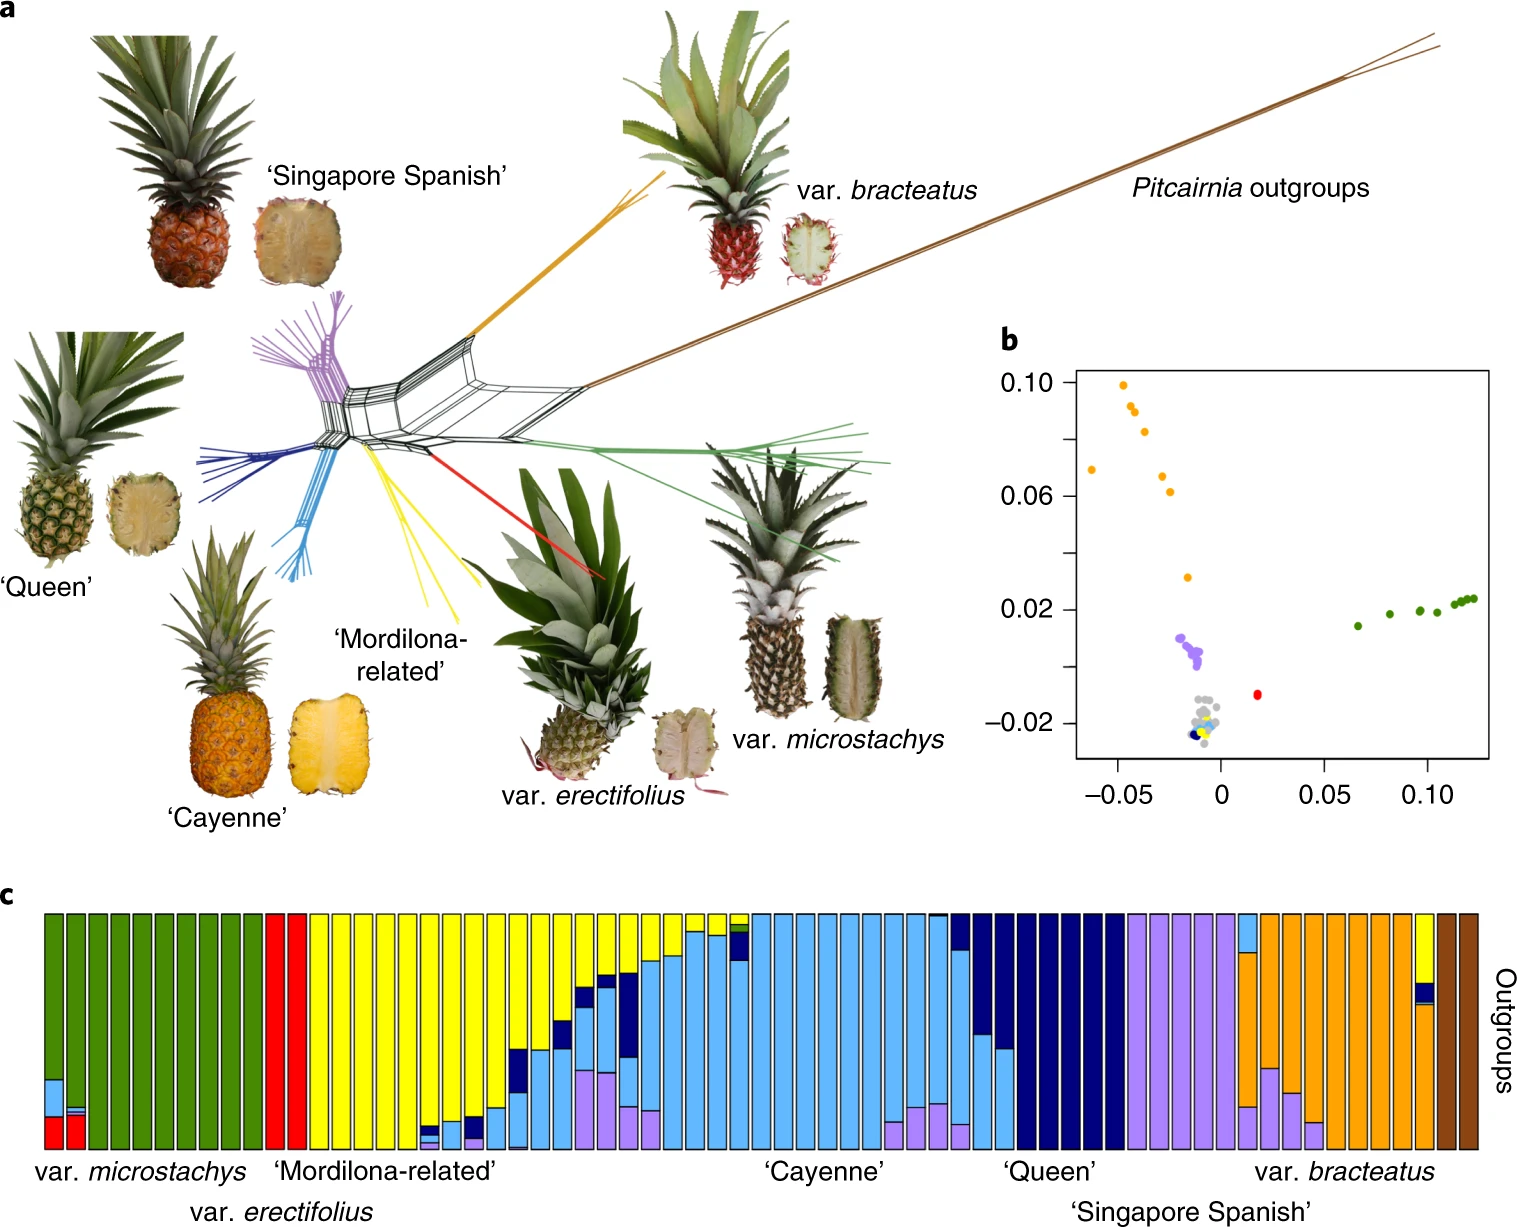

In this notebook, we imported a simplified vcf file containing a subset of the variants that were used in this paper. We can treat the file of variants as a character matrix and similar to the leaf shape and RNAseq data, use a principle component analysis to describe the data. There should be distinct sets of variants that are found in _only_ domesticated and _only_ wild pineapple, and they should lead to a strong separation of the two groups. The wild progenitor species of pineapple should contain a subset of variants that are shared with pineapple, so we might extpect these to be closer to the cultivated accessions than the wild. 

To run a PCA, we need a simple dataframe of integers (0, 1, and 2) instead of the complex numpy arrays we have after importing a vcf file. We can use the `allel.GenotypeChunkedArray` function to pull out only the genotype data (key 'calldata/GT'):

In [7]:
g = allel.GenotypeChunkedArray(pineapple['calldata/GT'])
g

<GenotypeChunkedArray shape=(20301, 87, 2) dtype=int8
   nbytes=3.4M
   values=numpy.ndarray>

This is simpler, but still not a simple enough input to run a PCA. We can use the `to_n_alt()` function transform each genotype call into the number of non-reference alleles. In this case, a 0/0 would be transformed into 0, 0/1 into 1, and 1/1 into 2:

In [8]:
gn = g.to_n_alt()
gn

<ChunkedArrayWrapper shape=(20301, 87) dtype=int8 chunks=(5076, 87)
   nbytes=1.7M cbytes=631.4K cratio=2.7
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

Then, we can use the `allel.pca` function to run the PCA. We need to feed it our simplified array, the number of components (set to 10), and the scaler (Patterson is based on the methods from the first paper to use PCA to survey genetic diversity):

In [9]:
coords1, model1 = allel.pca(gn, n_components=2, scaler='patterson')

Finally, we can plot the PCA. We will use matplotlib as we've done in the past. We will use the 'samples' array to label each sample. 

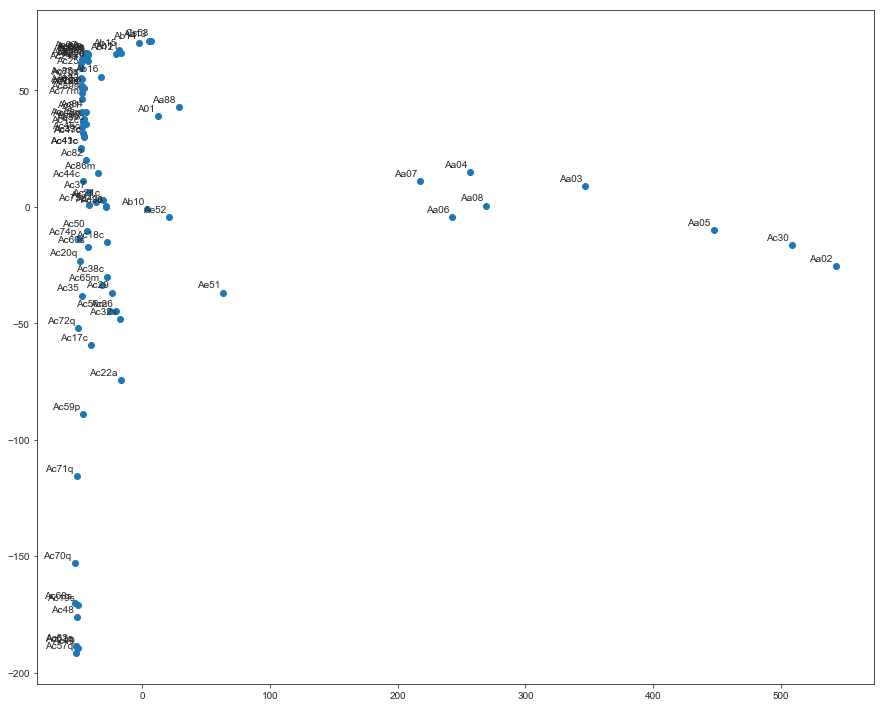

In [10]:
#plt.scatter(coords1[:,0], coords1[:,1])
import matplotlib.pyplot as plt

labels = pineapple['samples']
plt.figure(figsize=(15, 12))
plt.subplots_adjust(bottom=0.1)
plt.scatter(coords1[:,0],coords1[:,1], label='True Position')

for label, x, y in zip(labels, coords1[:, 0], coords1[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

We can similarly group the genetic data using a Hierarchical Clustering approach. This is similar to PCA and is often congruent with a phylogenetic approach. Below, samples are broken down into wild pineapple (in green) and domesticated (red):

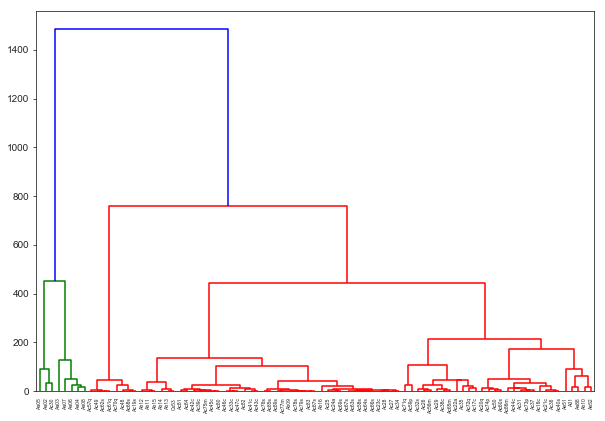

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(coords1, 'ward')

labelList = pineapple['samples']

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

# Bringing it together

We can apply this same framework to grape. Dan's collaborators have collected genotype data for each of the Vitis accessions we analyzed for the midterm. This includes many domesticated grape varieties and wild grape species. We previously used PCA with the shape data to cluster the accessions, but how does this compare to genotype data? Using the provided grape vcf file, run a PCA. I have also provided a sample dataframe and you can get creative to color the samples by species instead of labeling them. How does this compare to the previous PCA based on shape alone? <br>
The grape vcf file is derived from GBS data, and Dan's collaborator has heavily filtered the vcf file to contain only biallelic SNPs, with high depth and low missing data rates. 

In [ ]:
grape = allel.read_vcf('data/Phylogeny_out.biallele.depth.missing.recode.recalc.vcf')


In [ ]:
##Answer